    age   d18O
0 -61.0 -52.06
1 -33.0 -52.41
2   6.0 -53.76
3  50.0 -55.42
4  66.0 -56.50
Index(['age', 'd18O'], dtype='object')


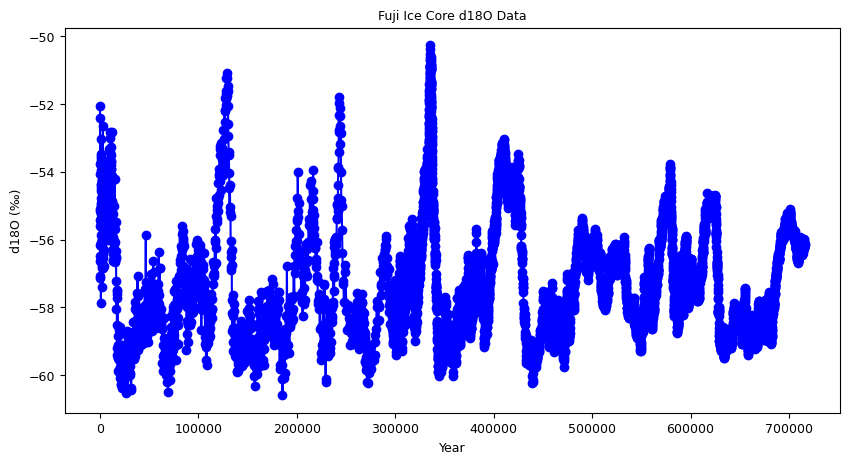

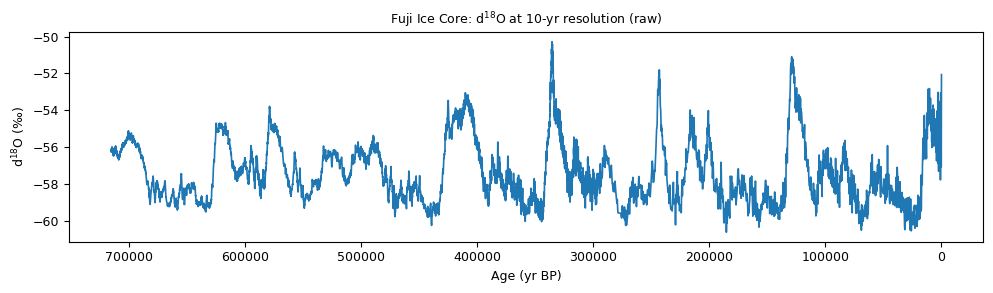

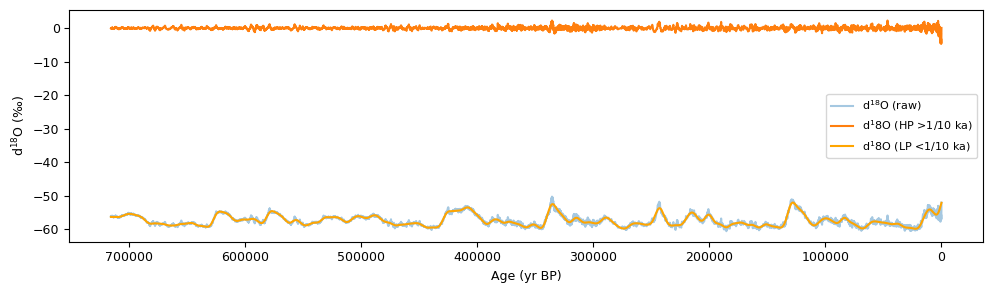

In [123]:
# Read the Fuji_d18O.xlsx file
import pandas as pd

file_path_fuji = r"D:\VScode\bipolar_seesaw_CCM\ice_core_data\Fuji_d18O.xlsx"
df_fuji = pd.read_excel(file_path_fuji)
print(df_fuji.head())
print(df_fuji.columns)

# drop nan
df_fuji = df_fuji.dropna()
# plot data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df_fuji['age'], df_fuji['d18O'], marker='o', linestyle='-', color='b')
plt.title('Fuji Ice Core d18O Data')
plt.xlabel('Year')
plt.ylabel('d18O (‰)')

 
# save the data to csv under Raw_data folder
df_fuji.to_csv(r"D:\VScode\bipolar_seesaw_CCM\Raw_data\Fuji_d18O.csv", index=False)

# # read the data from csv
# df_fuji = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\Raw_data\Fuji_d18O.csv")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


age_min = df_fuji['age'].min()
age_max = df_fuji['age'].max()
age_interp = np.arange(age_min, age_max + 1, 10)   # +1 to include the endpoint if it falls exactly

df_interp = pd.DataFrame({'age': age_interp})


df_fuji_sorted = df_fuji.sort_values('age')
df_interp['d18O'] = np.interp(
    df_interp['age'],
    df_fuji_sorted['age'].values,
    df_fuji_sorted['d18O'].values
)

# ── 4. (Optional) Quick sanity‐check plot of the interpolated series ──
plt.figure(figsize=(10, 3))
plt.plot(df_interp['age'], df_interp['d18O'], lw=1.2, color='tab:blue')
plt.xlabel('Age (yr BP)')
plt.ylabel('d$^{18}$O (‰)')
plt.title('Fuji Ice Core: d$^{18}$O at 10-yr resolution (raw)')
plt.gca().invert_xaxis()   # common in paleo to have older on the left
plt.tight_layout()
plt.show()

# ── 5. Set up Butterworth high‐pass filter parameters ──
dt = 10                               # sampling interval in years
cutoff_period = 10000                 # we want to remove variability longer than 10 000 yr
butter_order = 4

fs = 1.0 / dt                         # sampling frequency (samples per year)
fc = 1.0 / cutoff_period              # cutoff frequency in cycles per year
Wn = fc / (0.5 * fs)                  # normalized cutoff (to Nyquist)

b, a = butter(butter_order, Wn, btype='highpass')

# ── 6. Apply filtfilt → zero‐phase distortion ──
d18O_vals = df_interp['d18O'].values
filt_d18O = filtfilt(b, a, d18O_vals)

# ── 7. Wrap the result back into a DataFrame ──
df_filt = pd.DataFrame({
    'age': df_interp['age'].values,
    'd18O_hp': filt_d18O
})



fs = 1.0 / dt                        # samples per yr
# convert periods [yr] → frequencies [Hz]
f_low  = 1.0 / 10_000           # lower edge (remove slower than this)
f_high = 1.0 / 300            # upper edge (remove faster than this)
Wn = np.array([f_low, f_high]) / (fs * 0.5)   # normalised to Nyquist

b, a = butter(butter_order, Wn, btype='bandpass')
filt_d18O_band = filtfilt(b, a, d18O_vals)

df_filt_band = pd.DataFrame({
    'age': df_interp['age'].values,
    'd18O_hp': filt_d18O_band
})


fs = 1.0 / dt                         # sampling frequency (samples per year)
fc = 1.0 / cutoff_period              # cutoff frequency in cycles per year
Wn = fc / (0.5 * fs)                  # normalized cutoff (to Nyquist)
b, a = butter(butter_order, Wn, btype='lowpass')
filt_d18O_low = filtfilt(b, a, d18O_vals)

# ── 7. Wrap the result back into a DataFrame ──
df_filt_d18O_low = pd.DataFrame({
    'age': df_interp['age'].values,
    'd18O_hp': filt_d18O_low
})


max_age_plot = np.max(df_filt['age'])
mask = (df_filt['age'] <= max_age_plot)
df1 = df_interp[ df_interp['age'] <= max_age_plot ]
df2 = df_filt[ mask ]

# ── 9. Plot raw vs. high‐pass‐filtered on the same axes ──
plt.figure(figsize=(10, 3))
plt.plot(df1['age'], df1['d18O'],   alpha=0.4, label='d$^{18}$O (raw)')
plt.plot(df2['age'], df2['d18O_hp'], lw=1.5, label=f'd$^{18}$O (HP >1/{cutoff_period/1000:.0f} ka)')
plt.plot(df_interp['age'], filt_d18O_low, lw=1.5, label=f'd$^{18}$O (LP <1/{cutoff_period/1000:.0f} ka)', color='orange')
plt.gca().invert_xaxis()
plt.xlabel('Age (yr BP)')
plt.ylabel('d$^{18}$O (‰)')
plt.legend()
plt.tight_layout()
plt.show()



# df_filt_d18O = df_filt_band.copy()

df_filt_d18O= df_filt.copy()
# rename columns
df_filt_d18O.rename(columns={'d18O_hp': 'filt_d18O'}, inplace=True)

#save the filtered data to csv under filtered_data folder

df_filt_d18O.to_csv(r"D:\VScode\bipolar_seesaw_CCM\filtered_data\Fuji_d18O_filtered.csv", index=False)
df_filt_d18O_low.rename(columns={'d18O_hp': 'filt_d18O'}, inplace=True)
# save the low-pass filtered data to csv under filtered_data folder
df_filt_d18O_low.to_csv(r"D:\VScode\bipolar_seesaw_CCM\filtered_data\Fuji_d18O_low_filtered.csv", index=False)

# read the filtered data from csv
# df_filt_d18O_low = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\filtered_data\Fuji_d18O_low_filtered.csv")




# crop the data for age >10000 and <=640000
# df_filt_d18O = df_filt_d18O[(df_filt_d18O['age'] > 20000) & (df_filt_d18O['age'] <= 640000)]

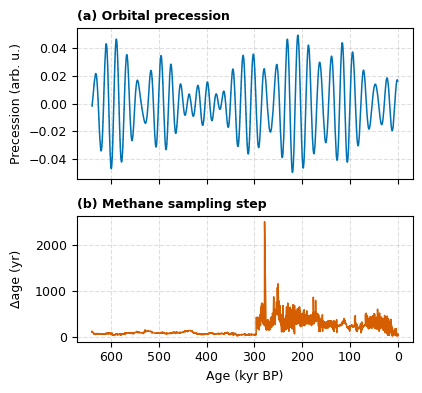

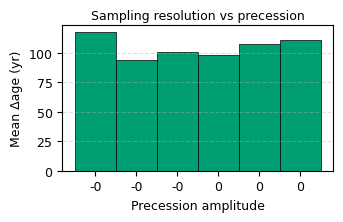

In [23]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

fig_pair, fig_bar = sa.age_gap_ana(
    df_fuji,
    age_min=0,
    age_max=640_000,
    pre_path=r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_800_inter100.txt",
    n_bins=6,
    tolerance=200
)



In [82]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fig = sa.age_gap_interactive(
    df_fuji,
    age_min=0,
    age_max=710_000,
    H_line=100,
)
fig.show()

Maximum Δage within 0-710000 yr BP: 2513 years
95% quantile of Δage: 280 years
Median Δage: 70 years


# TE dT plot

Running TE scan for window -61 to 399939 years
Running TE scan for window 9939 to 409939 years
Running TE scan for window 19939 to 419939 years
Running TE scan for window 29939 to 429939 years
Running TE scan for window 39939 to 439939 years
Running TE scan for window 49939 to 449939 years
Running TE scan for window 59939 to 459939 years
Running TE scan for window 69939 to 469939 years
Running TE scan for window 79939 to 479939 years
Running TE scan for window 89939 to 489939 years
Running TE scan for window 99939 to 499939 years
Running TE scan for window 109939 to 509939 years
Running TE scan for window 119939 to 519939 years
Running TE scan for window 129939 to 529939 years
Running TE scan for window 139939 to 539939 years
Running TE scan for window 149939 to 549939 years
Running TE scan for window 159939 to 559939 years
Running TE scan for window 169939 to 569939 years
Running TE scan for window 179939 to 579939 years
Running TE scan for window 189939 to 589939 years
Running TE sca

d:\VScode\bipolar_seesaw_CCM\toolbox\sq_ana.py:3229: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Processing window: 209939 to 609939 years
Processing window: 219939 to 619939 years
Processing window: 229939 to 629939 years
Processing window: 239939 to 639939 years
Processing window: 249939 to 649939 years
Processing window: 259939 to 659939 years
Processing window: 269939 to 669939 years
Processing window: 279939 to 679939 years
Processing window: 289939 to 689939 years
Processing window: 299939 to 699939 years
Processing window: 309939 to 709939 years
      dt     te_xy  p_xy     te_yx  p_yx  sig_uni  window_start  window_end
0     10  0.000168  0.81  0.000114  0.28    False         -61.0    399939.0
1     20  0.000343  0.81  0.000226  0.37    False         -61.0    399939.0
2     30  0.000551  0.79  0.000346  0.27    False         -61.0    399939.0
3     40  0.000722  0.85  0.000453  0.25    False         -61.0    399939.0
4     50  0.000917  0.83  0.000303  0.66    False         -61.0    399939.0
..   ...       ...   ...       ...   ...      ...           ...         ...
347   

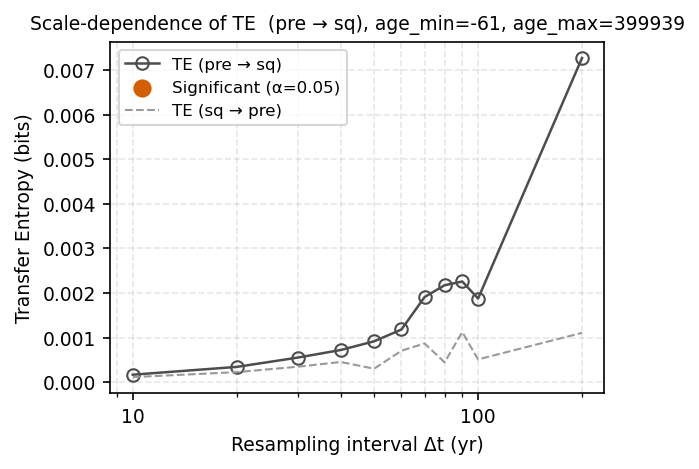

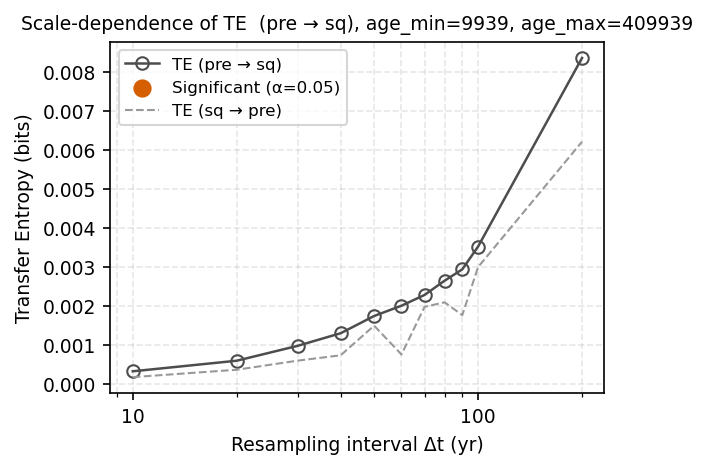

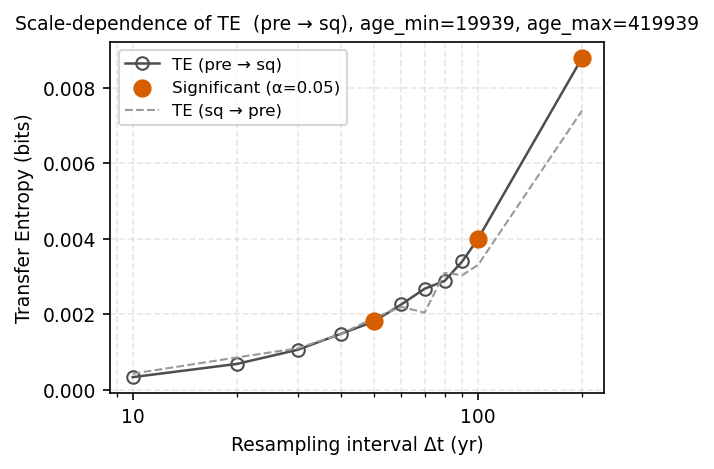

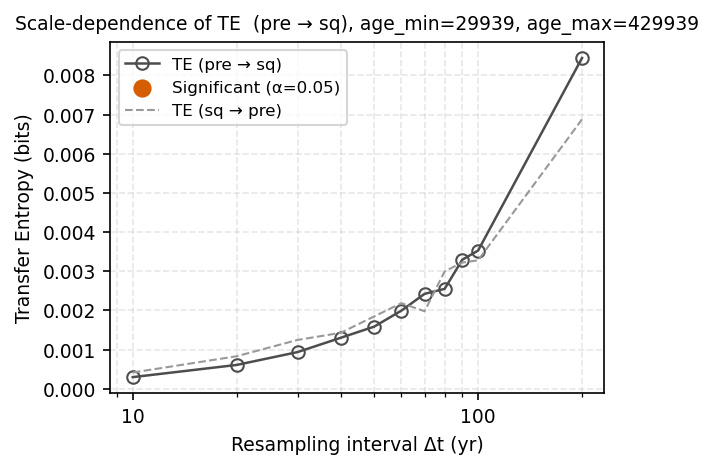

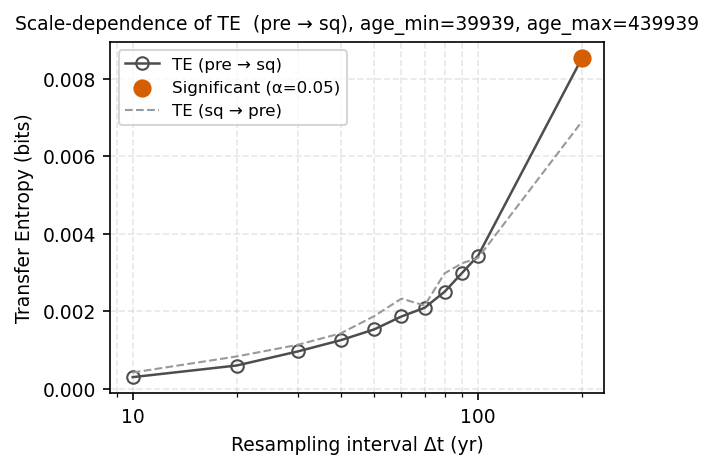

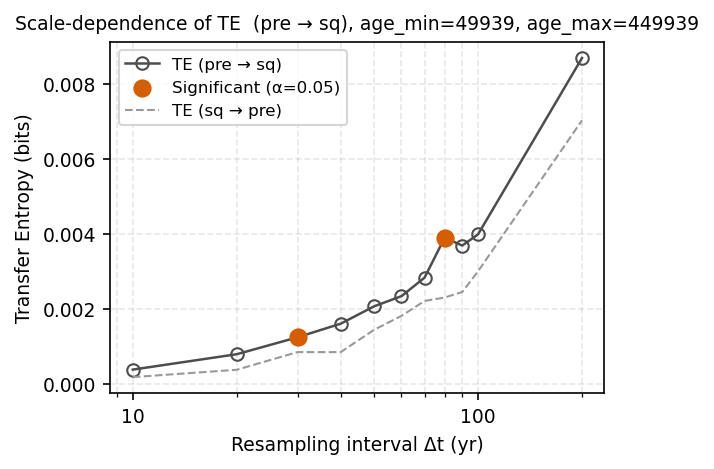

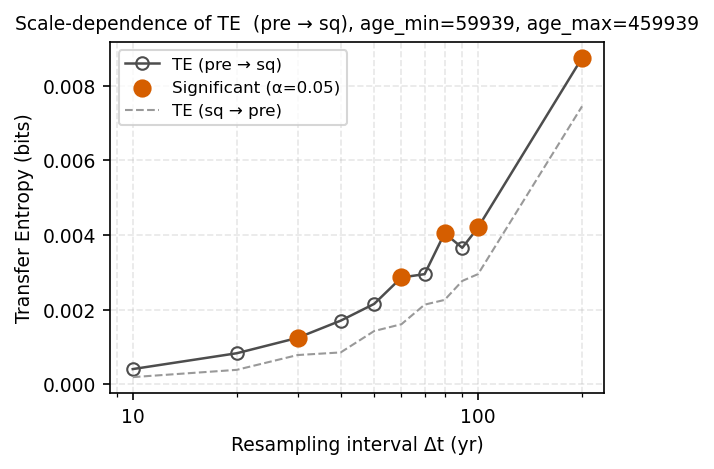

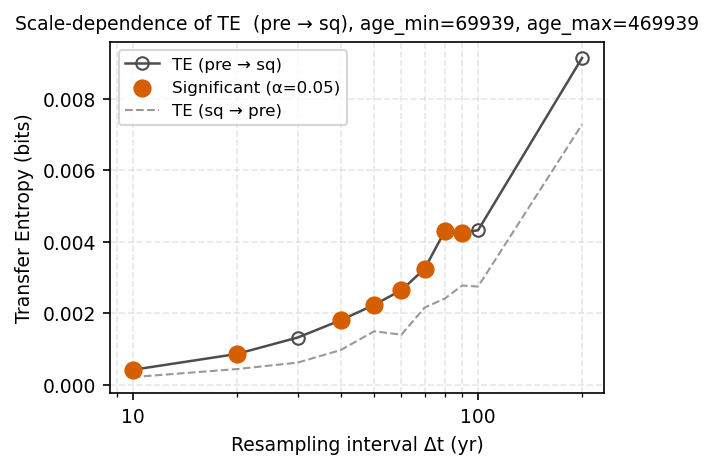

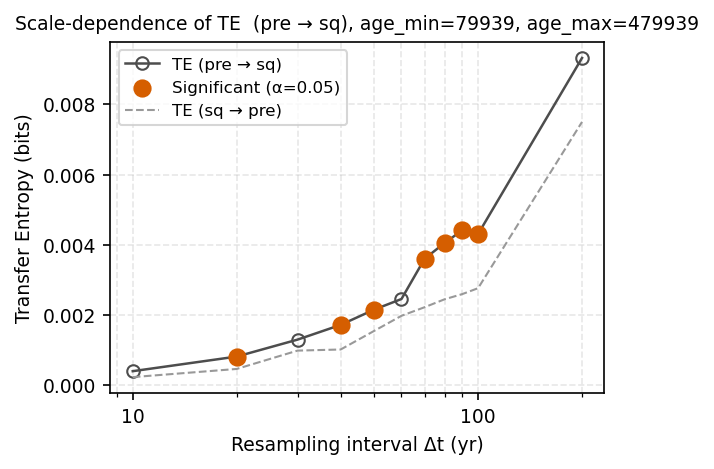

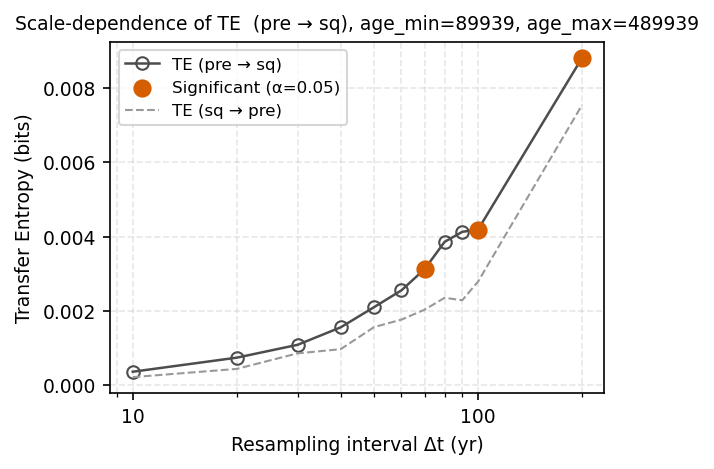

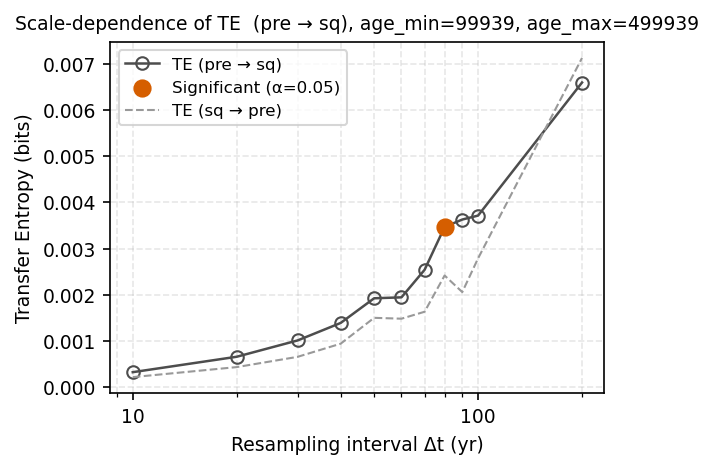

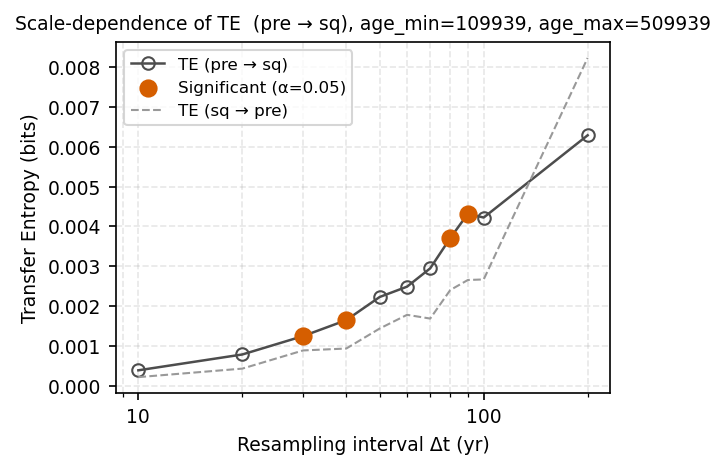

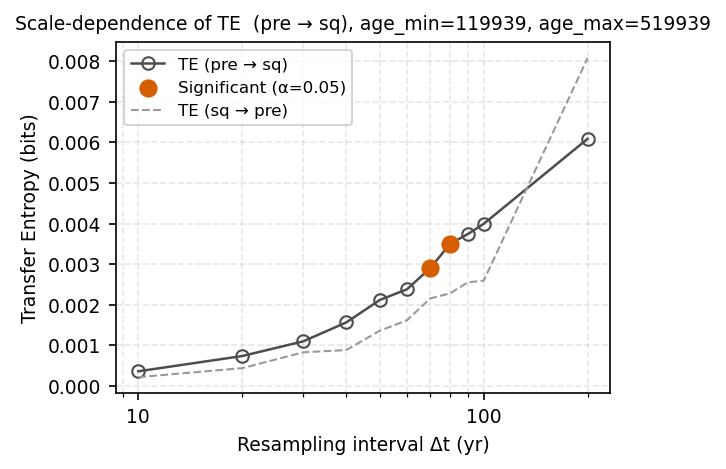

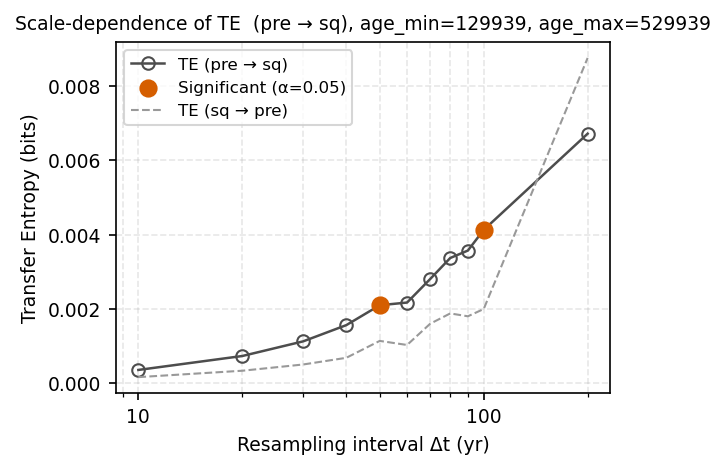

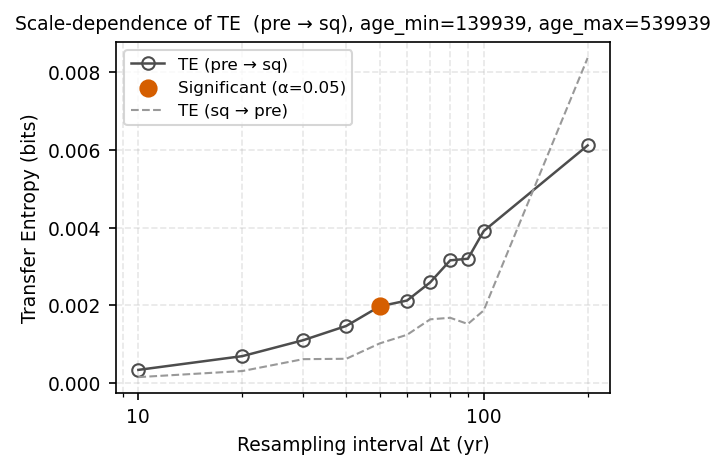

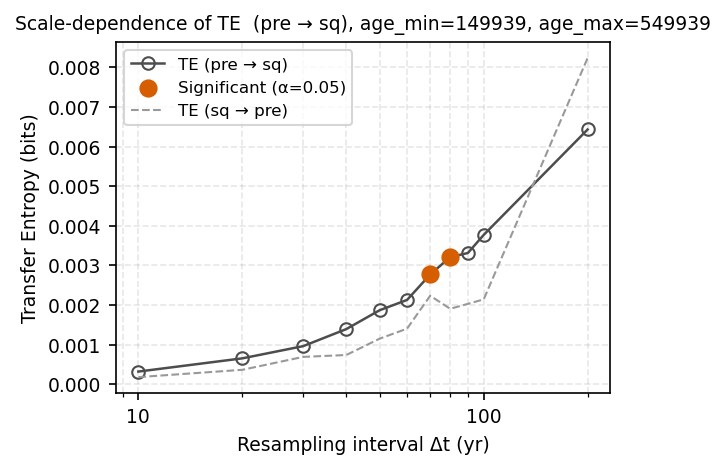

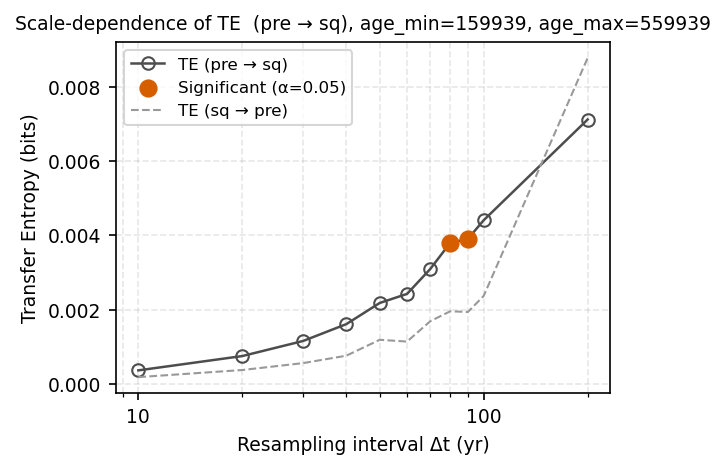

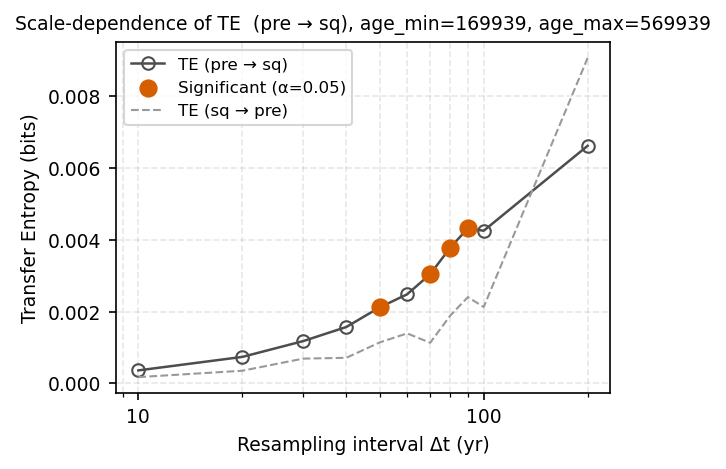

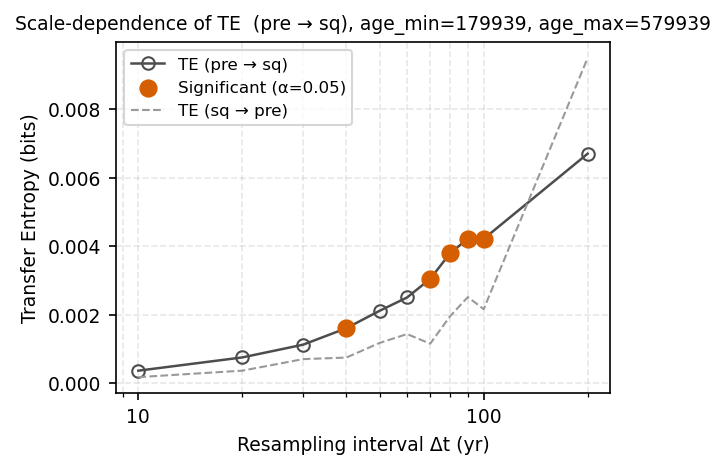

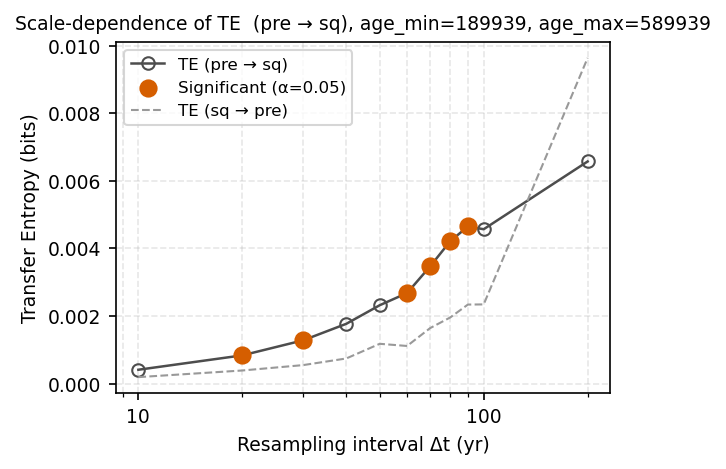

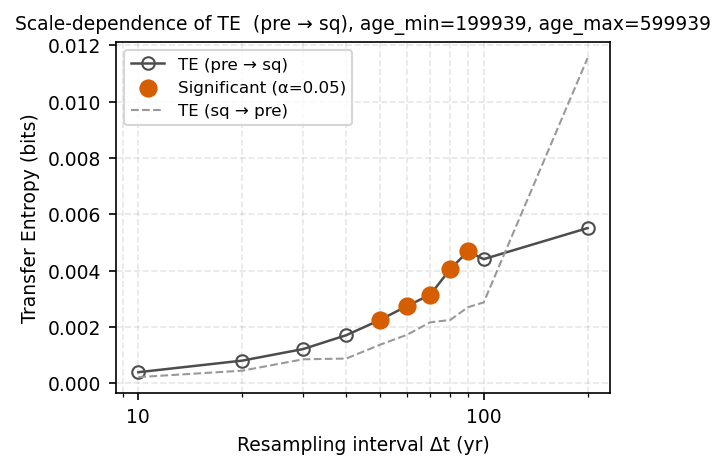

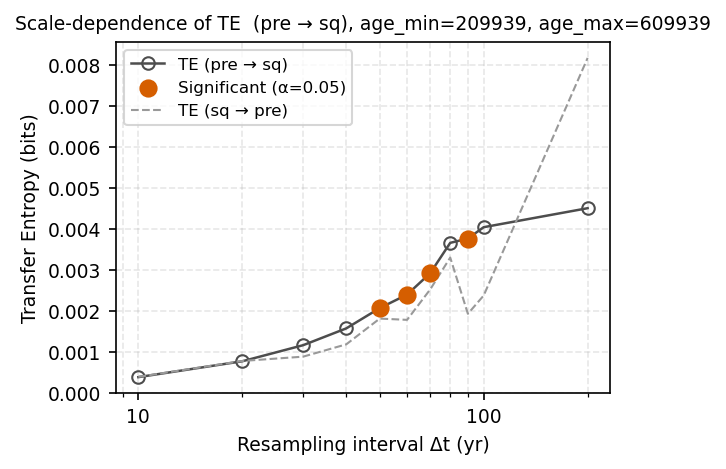

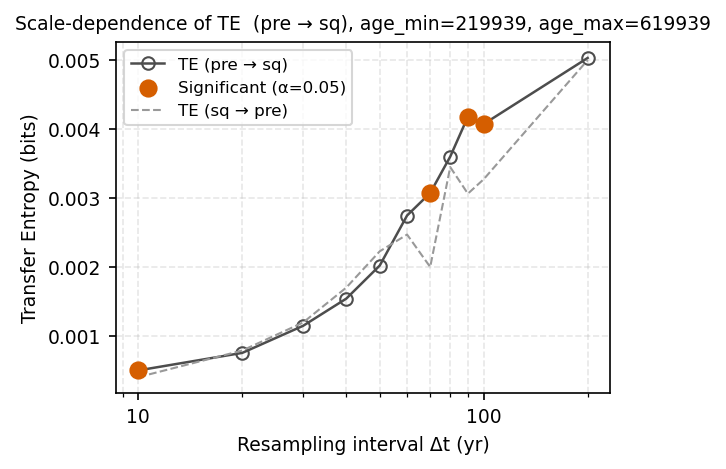

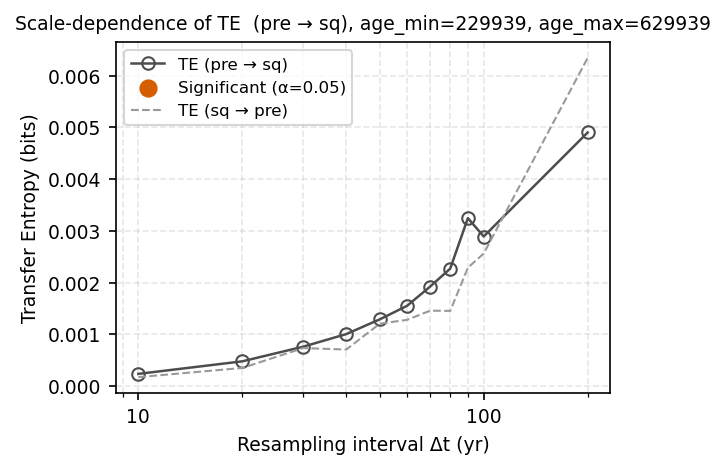

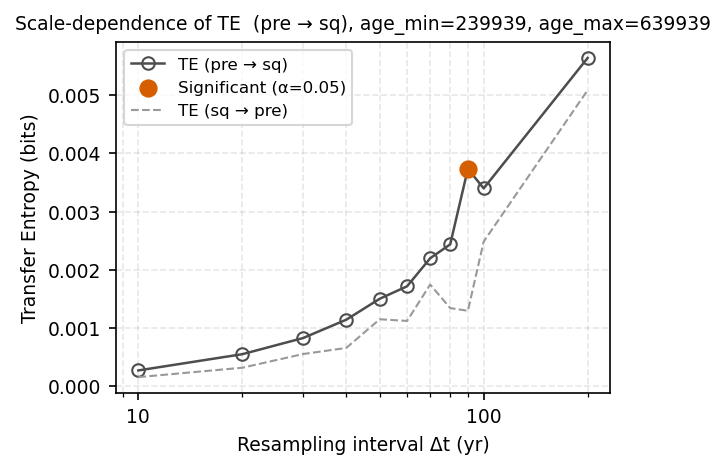

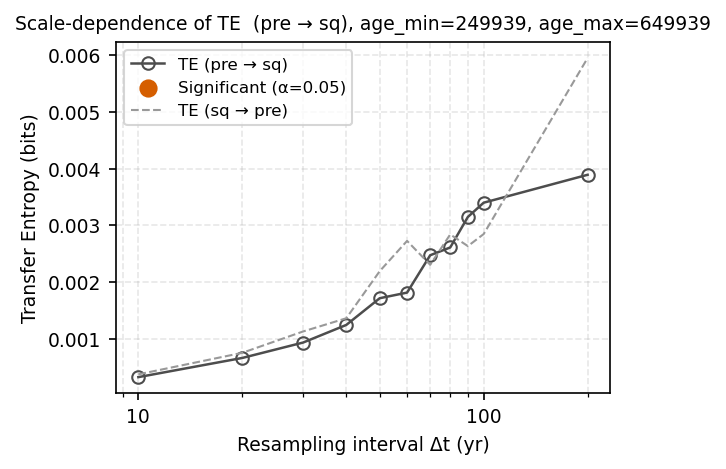

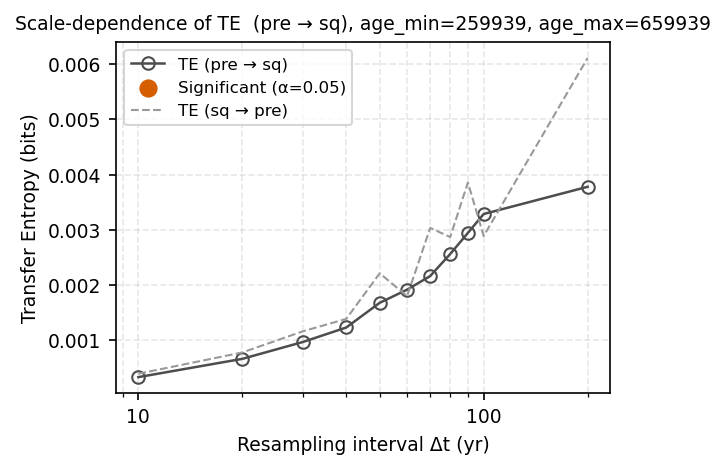

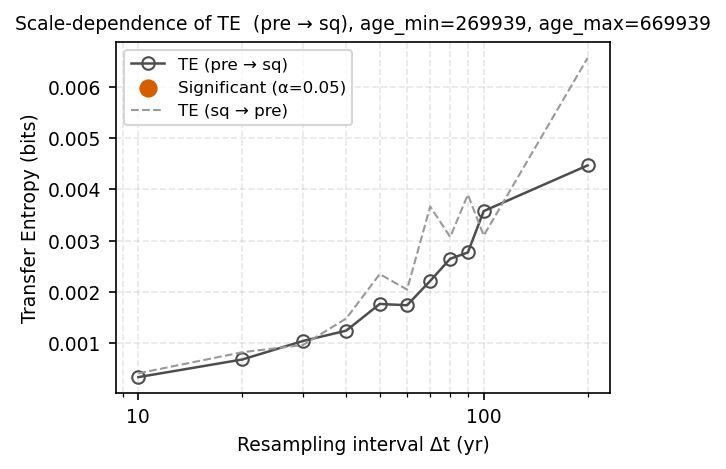

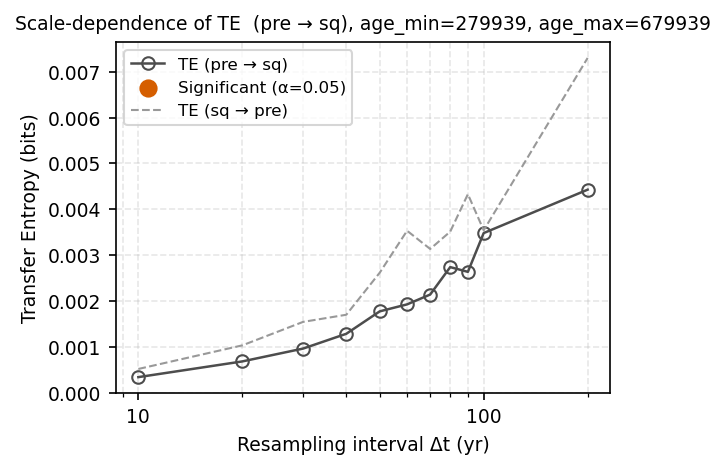

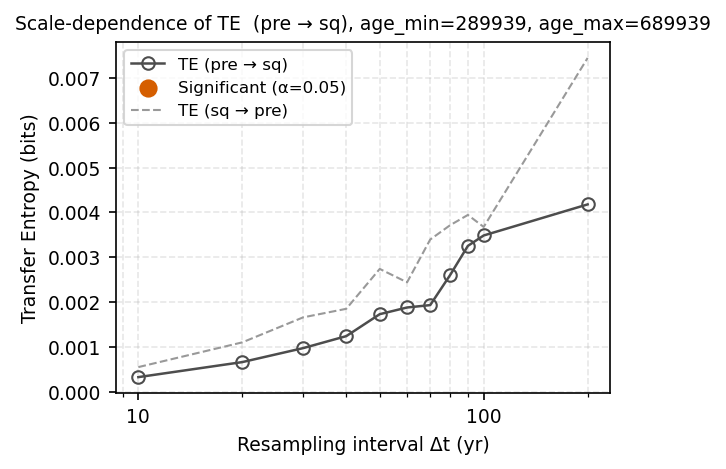

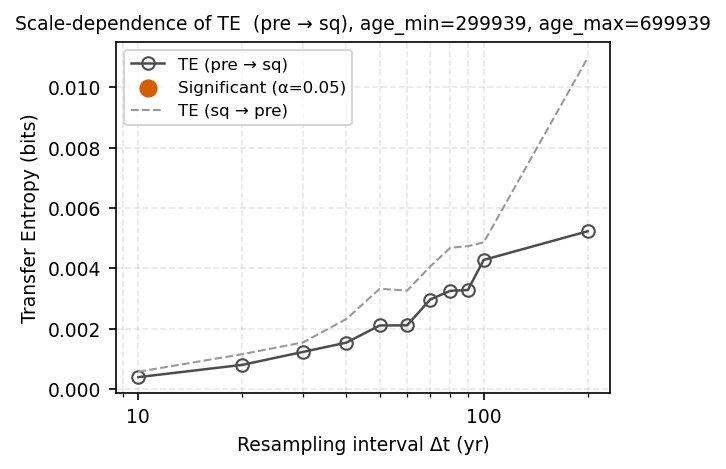

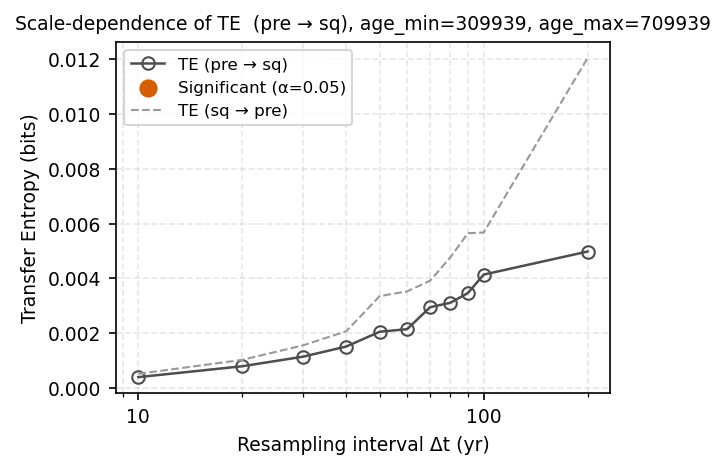

In [109]:
from toolbox import sq_ana as sa
import importlib
importlib.reload(sa)
import numpy as np

# parameters
window_size = 400_000     # size of sliding window in years
step = 10_000             # step size in years

df = df_filt_d18O.copy()
# overall age range
age_min = df['age'].min()
age_max = df['age'].max()

# prepare to collect results
all_results = []

# slide the window from age_min to age_max
for start in np.arange(age_min, age_max - window_size + 1, step):
    end = start + window_size
    # crop the dataframe for the current window
    df_crop = df[(df['age'] >= start) & (df['age'] <= end)]

    # skip if there is not enough data in this window
    if df_crop.empty:
        continue

    print(f"Running TE scan for window {int(start)} to {int(end)} years")

    # run the transfer entropy vs dt scan
dt_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]  # time steps in years
for start in np.arange(age_min, age_max - window_size + 1, step):
    end = start + window_size
    # print start and end of the window
    print(f"Processing window: {int(start)} to {int(end)} years")
    df_crop = df[(df['age'] >= start) & (df['age'] <= end)]
    if df_crop.empty:
        continue

    te_df, (fig, ax) = sa.te_vs_dt_scan(
        df_crop,
        dt_steps,
        forcing_bins=6,
        sq_bins=2,
        k=1,
        n_surr=100,
        alpha=0.05,
        sq_method='hist',
        dpi=150
    )

    # annotate results with window boundaries
    te_df['window_start'] = start
    te_df['window_end'] = end

    # collect
    all_results.append(te_df)

# combine all window results into one DataFrame
import pandas as pd
results_df = pd.concat(all_results, ignore_index=True)

# inspect
print(results_df)


     dt     te_xy  p_xy     te_yx  p_yx  sig_uni
0    10  0.000329  0.19  0.000392  0.06    False
1    20  0.001285  0.00  0.001106  0.00    False
2    30  0.001480  0.00  0.001291  0.02    False
3    40  0.002534  0.00  0.002077  0.00    False
4    50  0.001544  0.23  0.001932  0.04    False
5    60  0.002339  0.09  0.002490  0.04    False
6    70  0.003539  0.00  0.003470  0.02    False
7    80  0.003163  0.07  0.004721  0.00    False
8    90  0.002220  0.39  0.003504  0.04    False
9   100  0.003848  0.07  0.003232  0.20    False
10  200  0.006577  0.22  0.006330  0.16    False


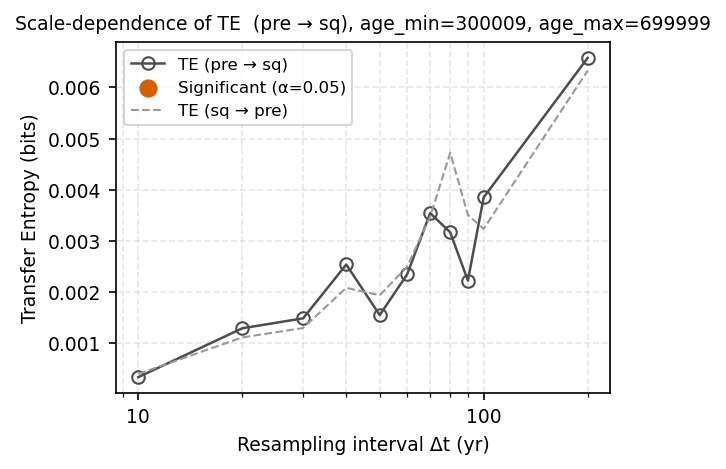

In [125]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

# df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 70_000) & (df_filt_d18O['age'] <= 470_000)]
# df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 350000) & (df_filt_d18O['age'] <= 590000)]
# df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 320000) & (df_filt_d18O['age'] <= 560000)]
df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 300_000) & (df_filt_d18O['age'] <= 700_000)]
# df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 300000)]
# df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 110_000) & (df_filt_d18O['age'] <= 700_000)]
# df_filt_d18O_crop = df_filt_d18O.copy()[(df_filt_d18O['age'] > 1000) & (df_filt_d18O['age'] <= 270000)]
dt_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]          # yr

# run the scan
te_df, (fig, ax) = sa.te_vs_dt_scan(
    df_filt_d18O_crop,                 # your raw sq-series
    dt_steps,
    forcing_bins=6, sq_bins=2,
    k=1,
    n_surr=100, alpha=0.05,
    sq_method='hist',            # or 'quantile', 'kmeans'
    dpi=150)

# te_df now holds the numbers:
print(te_df)


     dt     te_xy  p_xy     te_yx  p_yx  sig_uni
0    10  0.000104  0.79  0.000080  0.14    False
1    20  0.000217  0.85  0.000158  0.22    False
2    30  0.000346  0.65  0.000243  0.16    False
3    40  0.000457  0.71  0.000320  0.25    False
4    50  0.000564  0.64  0.000252  0.41    False
5    60  0.000748  0.68  0.000497  0.25    False
6    70  0.001109  0.32  0.000622  0.16    False
7    80  0.001298  0.27  0.000374  0.52    False
8    90  0.001340  0.44  0.000803  0.12    False
9   100  0.001046  0.80  0.000279  0.68    False
10  200  0.004071  0.10  0.000603  0.80    False


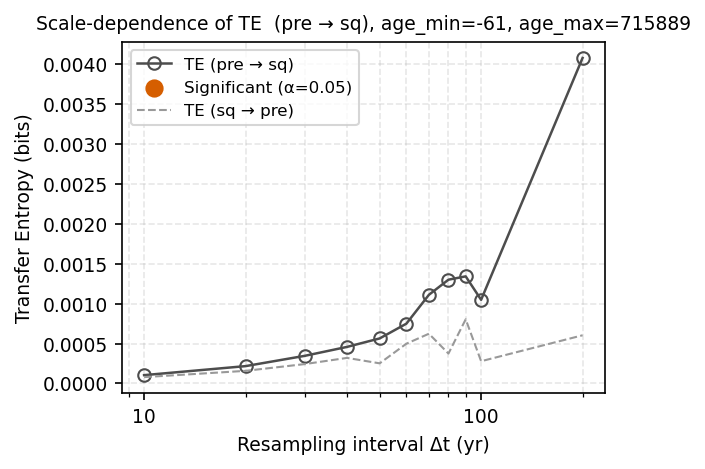

In [67]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


dt_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]          # yr

# run the scan
te_df, (fig, ax) = sa.te_vs_dt_scan(
    df_filt_d18O,                 # your raw sq-series
    dt_steps,
    forcing_bins=6, sq_bins=2,
    k=1,
    n_surr=100, alpha=0.05,
    sq_method='hist',            # or 'quantile', 'kmeans'
    dpi=150)

# te_df now holds the numbers:
print(te_df)


     dt     te_xy   p_xy     te_yx   p_yx  sig_uni
0    10  0.000152  0.510  0.000153  0.465    False
1    20  0.000316  0.500  0.000252  0.640    False
2    30  0.000497  0.450  0.000402  0.545    False
3    40  0.000587  0.590  0.000637  0.480    False
4    50  0.000823  0.405  0.000703  0.490    False
5    60  0.001143  0.295  0.000555  0.785    False
6    70  0.001006  0.565  0.000767  0.665    False
7    80  0.001526  0.265  0.000995  0.580    False
8    90  0.001783  0.300  0.000826  0.810    False
9   100  0.001136  0.810  0.001491  0.370    False
10  200  0.002515  0.795  0.003502  0.255    False


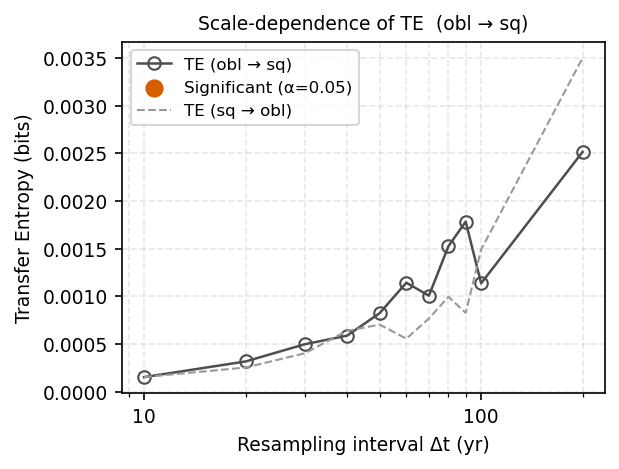

In [4]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


dt_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]          # yr

# run the scan
te_df, (fig, ax) = sa.te_vs_dt_scan(
    df_filt_d18O,                 # your raw sq-series
    dt_steps,
    forcing='obl',
    forcing_bins=6, sq_bins=2,
    n_surr=200, alpha=0.05,
    sq_method='hist',            # or 'quantile', 'kmeans'
    dpi=150)

# te_df now holds the numbers:
print(te_df)

# TE from pre and obl to d18O MCV (dt=10)

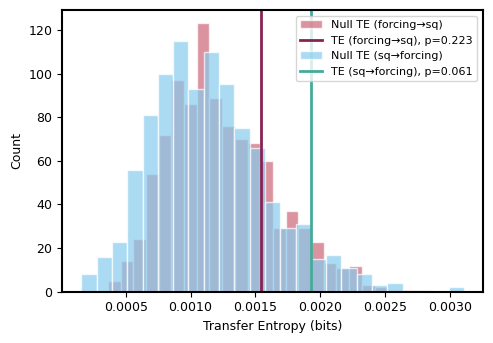

False


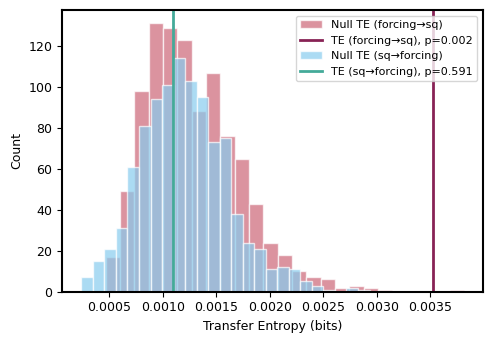

True


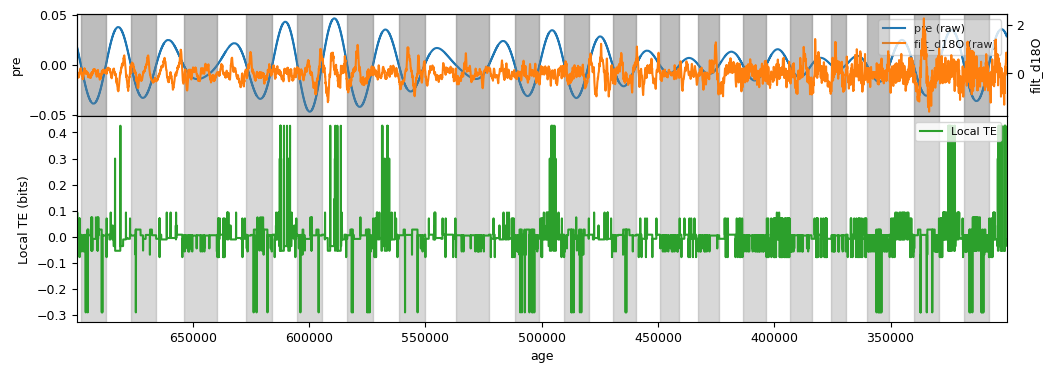

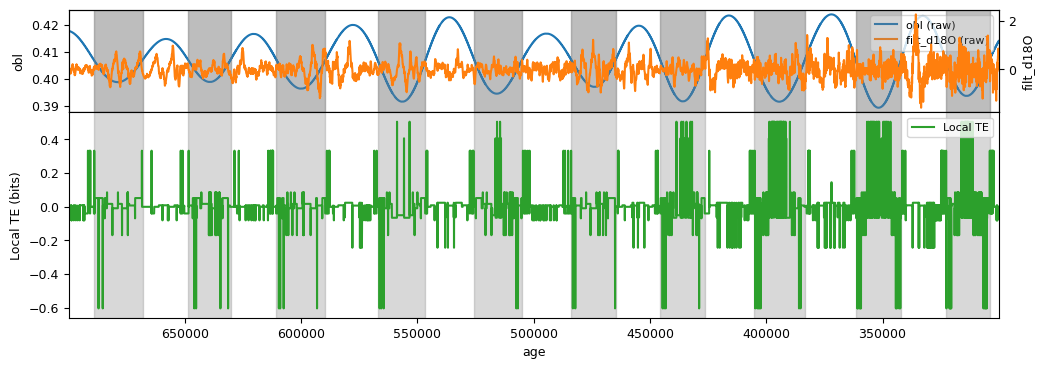

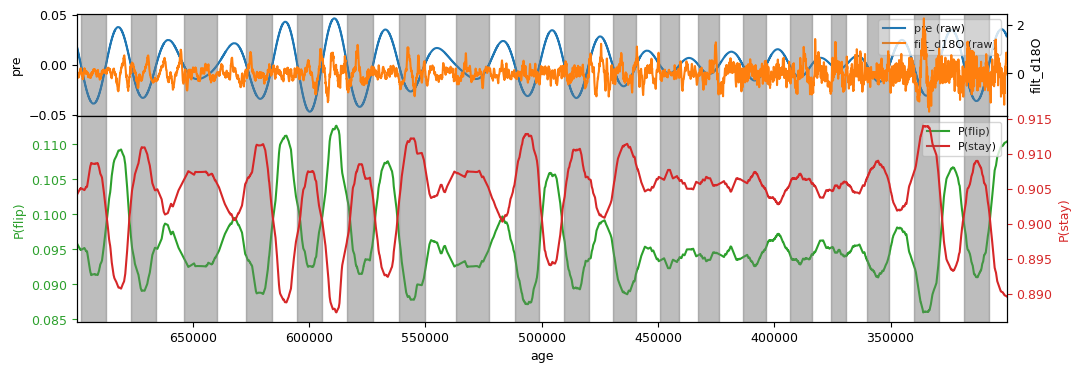

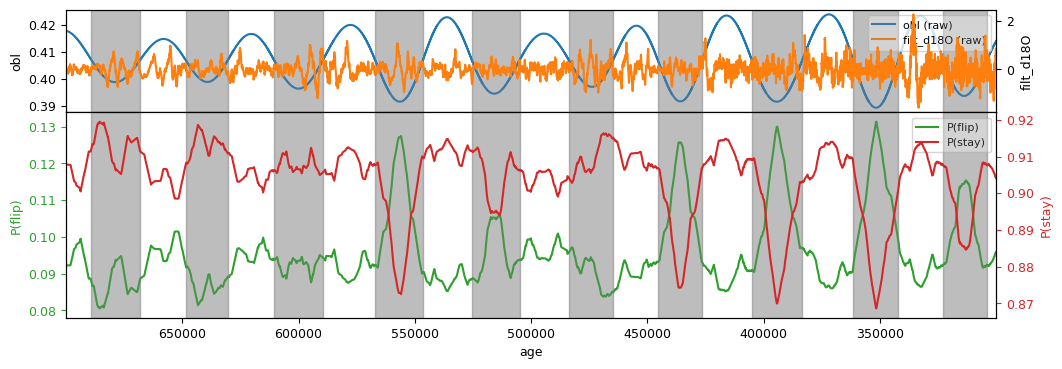

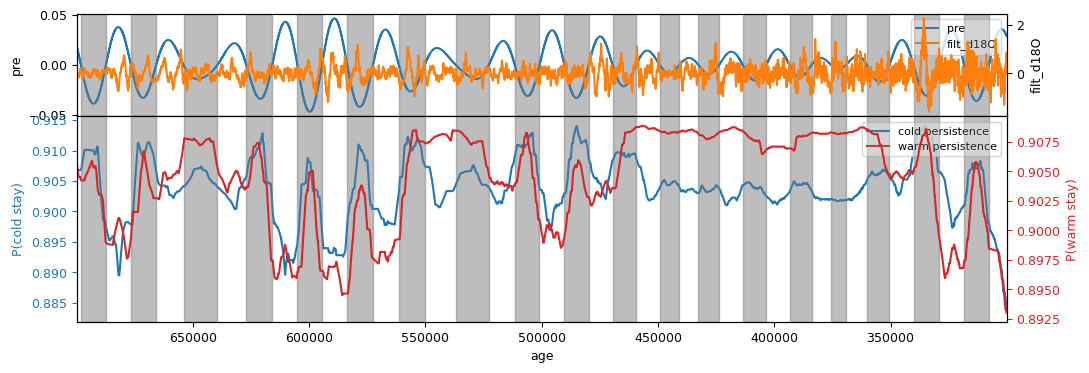

In [126]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


dt=50

# df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy()[(df_filt_d18O['age'] > 70_000) & (df_filt_d18O['age'] <= 470_000)], dt, if_plot=False)
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy()[(df_filt_d18O['age'] > 300_000) & (df_filt_d18O['age'] <= 700_000)], dt, if_plot=False)
# df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy()[(df_filt_d18O['age'] > 80000) & (df_filt_d18O['age'] <= 480000)], dt, if_plot=False)
# df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy()[(df_filt_d18O['age'] > 320000) & (df_filt_d18O['age'] <= 560000)], dt, if_plot=False)
# df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy()[(df_filt_d18O['age'] > 350000) & (df_filt_d18O['age'] <= 590000)], dt, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig, te_pre=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig, te_obl=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=1000)
print(result)


LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)



Lp = sa.local_prob(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)




Lp = sa.local_prob(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)

# Where the TE comes from

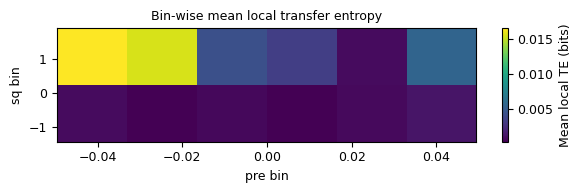

In [112]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


te_grid=sa.heatmap_binwise_local_te(
        pre=pre, sq=sq,
        pre_bins=6, sq_bins=2)

# te_grid=sa.heatmap_binwise_local_te(
#         pre=obl, sq=sq,
#         pre_bins=6, sq_bins=2)

# Frequency domain TE

[ 2.          2.11094231  2.22803872  2.3516306   2.48207827  2.61976202
  2.76508324  2.91846561  3.08035627  3.25122719  3.43157651  3.62193003
  3.82284267  4.03490017  4.25872075  4.49495691  4.74429736  5.00746902
  5.28523911  5.57841743  5.88785869  6.21446501  6.55918857  6.92303433
  7.30706305  7.71239428  8.1402097   8.59175654  9.0683512   9.57138312
 10.1023188  10.66270609 11.25417872 11.87846102 12.53737297 13.23283554
 13.96687621 14.74163497 15.5593705  16.42246676 17.33343996 18.2949459
 19.30978769 20.38092393 21.51147732 22.70474383 23.9642022  25.29352418
 26.69658519 28.17747562 29.74051275 31.39025335 33.13150697 34.96934994
 36.90914019 38.95653284 41.11749673 43.39833178 45.80568738 48.34658179
 51.02842254 53.85902809 56.84665061 60.        ]
max-power row = 52   →  period ≈ 22.8 ka


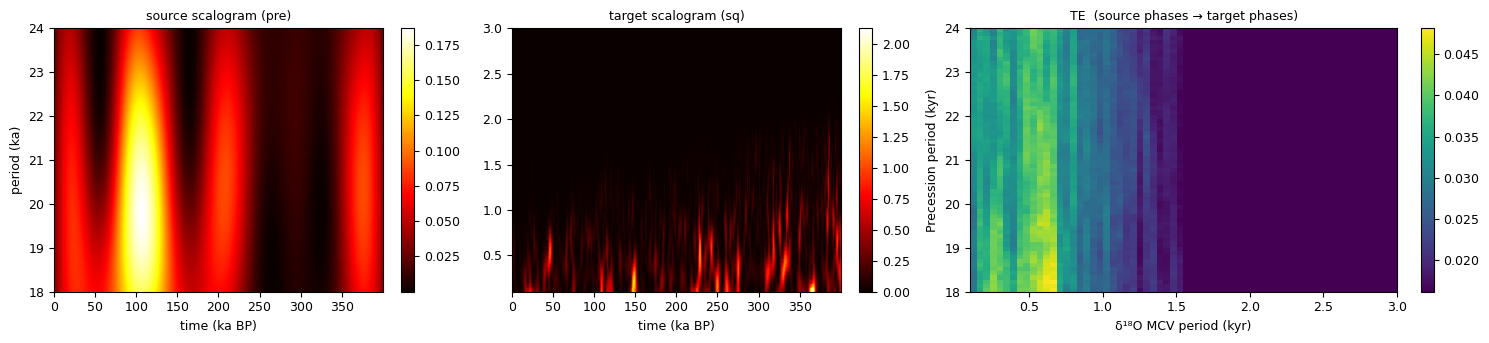

In [122]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

te_mat, p_src, p_trg = sa.freq_resolved_te(
    x = pre,             # forcing   (chronological order!)
    y = sq,              # response
    sampling_period = dt,     # yr/pt
    # source band: narrow around 20 ka
    src_min_period = 18_000,
    src_max_period = 24_000,
    n_src_scales   = 64,
    # target band: 0.1–3 ka
    trg_min_period = 2*dt,
    trg_max_period = 3_000,
    n_trg_scales   = 64,
    k = 1,
    plot = True,
    source_vname='Precession',       # e.g. 'pre'
    target_vname='δ¹⁸O MCV'        # e.g. 'sq'
)

max-power row = 63   →  period ≈ 24.00 ka


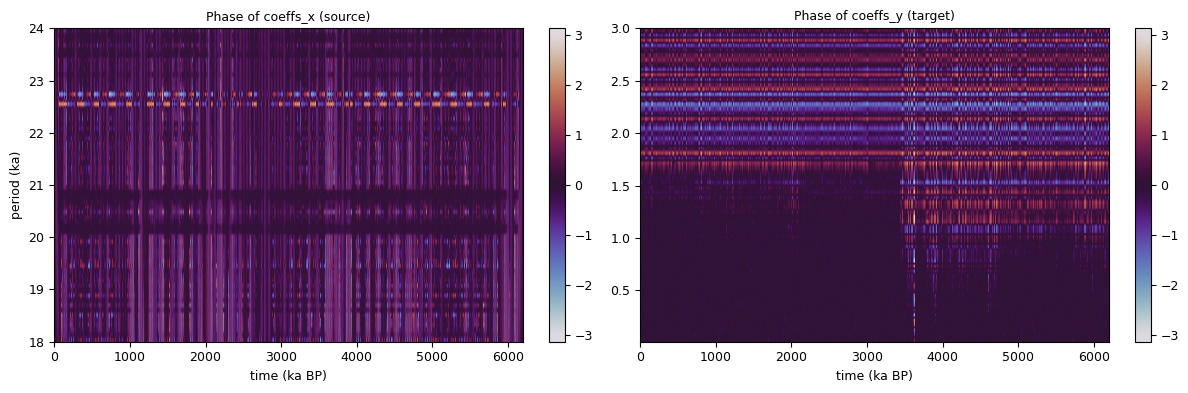

In [29]:

wavelet          = 'cmor1.5-1.0'
sampling_period  = 100            # yr per sample (→ 0.05 ka on the x-axis)

# --- source (forcing) band: 18–24 ka  -------------------------------
src_min_period   = 18_000        # yr
src_max_period   = 24_000
n_src_scales     = 64

# --- target (response) band: 0.01–3 ka  ----------------------------
trg_min_period   = 10            # yr
trg_max_period   = 3_000
n_trg_scales     = 64

# ---------------------------------------------------------------------
# 2. data  – IMPORTANT: the function reverses time, so we do the same
# ---------------------------------------------------------------------
x = pre[::-1].copy()             # forcing, oldest sample first
y = sq[::-1].copy()              # response

# ---------------------------------------------------------------------
# 3. helper to turn periods → scales  (identical to the function code)
# ---------------------------------------------------------------------
import numpy as np, pywt, matplotlib.pyplot as plt

fc = pywt.central_frequency(wavelet)          # wavelet’s centre freq

def build_scales(min_p, max_p, n_sc):
    if np.isclose(min_p, max_p):              # “single” band → 3-ish neighbours
        ctr      = min_p
        periods  = ctr * np.geomspace(0.8, 1.2, n_sc)
    else:                                     # log-space band
        periods  = np.geomspace(min_p, max_p, n_sc)
    scales = periods * fc / sampling_period   # ➜ pywt scale formula
    return periods, scales

periods_x, scales_x = build_scales(src_min_period, src_max_period, n_src_scales)
periods_y, scales_y = build_scales(trg_min_period, trg_max_period, n_trg_scales)

# ---------------------------------------------------------------------
# 4. continuous wavelet transforms
# ---------------------------------------------------------------------
coeffs_x, _ = pywt.cwt(x, scales_x, wavelet, sampling_period=sampling_period)
coeffs_y, _ = pywt.cwt(y, scales_y, wavelet, sampling_period=sampling_period)

phase_x = np.angle(coeffs_x)       # shape (n_src_scales, N)
phase_y = np.angle(coeffs_y)       # shape (n_trg_scales, N)

# ---------------------------------------------------------------------
# 5. quick diagnostic: which source period carries the most power?
#    (duplicates the print-statement in the original)
# ---------------------------------------------------------------------
row_max = (np.abs(coeffs_x)**2).mean(axis=1).argmax()
print(f"max-power row = {row_max}   →  period ≈ {periods_x[row_max]/1000:.2f} ka")

# ---------------------------------------------------------------------
# 6. plot phase (“angle scalogram”) for x and y
# ---------------------------------------------------------------------
t_ka = np.arange(x.size) * sampling_period / 1000    # time axis in kyr BP

extent_src = [t_ka[0], t_ka[-1], periods_x[0]/1000, periods_x[-1]/1000]
extent_trg = [t_ka[0], t_ka[-1], periods_y[0]/1000, periods_y[-1]/1000]

fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       gridspec_kw={'width_ratios':[1,1]})

im0 = ax[0].imshow(phase_x, origin='upper', aspect='auto',
                   cmap='twilight', extent=extent_src)
ax[0].set_title('Phase of coeffs_x (source)')
ax[0].set_xlabel('time (ka BP)')
ax[0].set_ylabel('period (ka)')
plt.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(phase_y, origin='upper', aspect='auto',
                   cmap='twilight', extent=extent_trg)
ax[1].set_title('Phase of coeffs_y (target)')
ax[1].set_xlabel('time (ka BP)')
plt.colorbar(im1, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()


In [60]:
# from toolbox import sq_ana as sa 
# import importlib
# importlib.reload(sa)

# te_mat, p_src, p_trg = sa.freq_resolved_te(
#     x = obl,             # forcing   (chronological order!)
#     y = sq,              # response
#     sampling_period = 100,     # yr/pt
#     # source band: narrow around 20 ka
#     src_min_period = 35_000,
#     src_max_period = 50_000,
#     n_src_scales   = 64,
#     # target band: 0.1–3 ka
#     trg_min_period = 10,
#     trg_max_period = 3_000,
#     n_trg_scales   = 64,
#     k = 1,
#     plot = True,
#     source_vname='Obliquity',       # e.g. 'pre'
#     target_vname='δ¹⁸O MCV'        # e.g. 'sq'
# )

# P stay P flip analysis

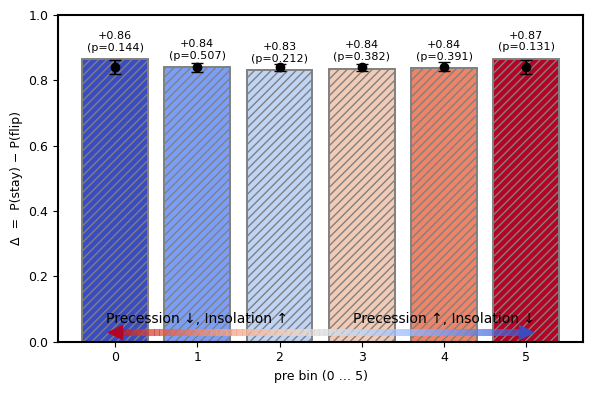

In [114]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre_i, df_sq_i,
        forcing_column='pre',
        target_column='filt_d18O',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        y_min=0,
        y_max=1,
        random_state=0   # reproducible
)


# delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
#         df_obl_i, df_sq_i,
#         forcing_column='obl',
#         target_column='filt_d18O',
#         nbins_pre=6,
#         n_surr=1000,
#         alpha=0.05,
#         random_state=0   # reproducible
# )


# P warm stay and P cold stay

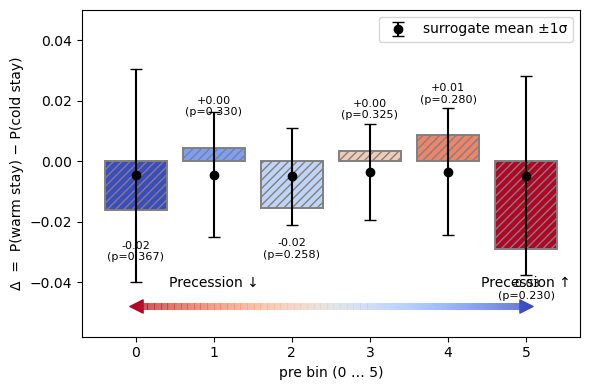

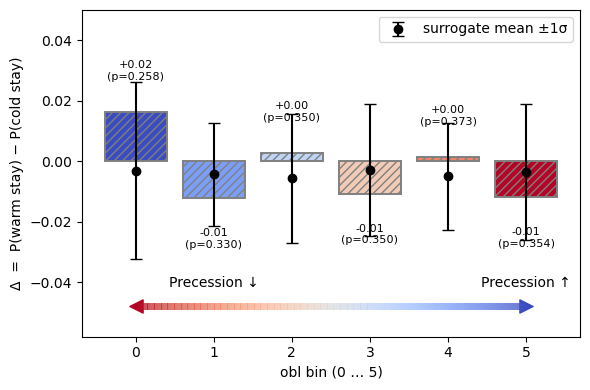

In [48]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

delta, mu, sd, p = sa.prob_prebins_staydiff_surr(
    df_pre      = df_pre_i,
    df_sq       = df_sq_i,
    forcing_column='pre',
    target_column='filt_d18O',
    nbins_pre   = 6,
    n_surr      = 1000,
    alpha       = 0.05,
    random_state=0
)
delta, mu, sd, p = sa.prob_prebins_staydiff_surr(
    df_pre      = df_obl_i,
    df_sq       = df_sq_i,
    forcing_column='obl',
    target_column='filt_d18O',
    nbins_pre   = 6,
    n_surr      = 1000,
    alpha       = 0.05,
    random_state=0
)

# The following are sensitivity tests

# Bin count

(6200,) (6200,) (6200,)
      pre=0  pre=1  pre=2  pre=3  pre=4  pre=5
sq=0    218    520    841    806    509    247
sq=1    207    502    751    838    539    222


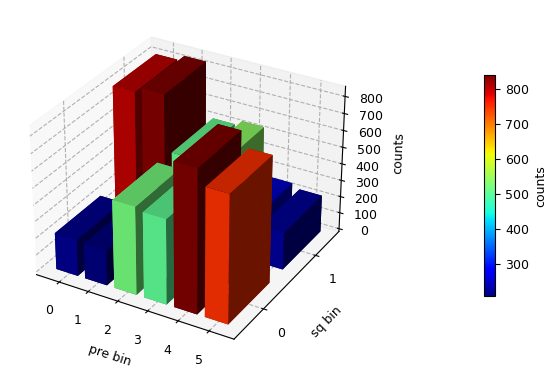

      pre=0  pre=1  pre=2  pre=3  pre=4  pre=5
sq=0    274    706    514    501    671    475
sq=1    306    647    522    471    656    457


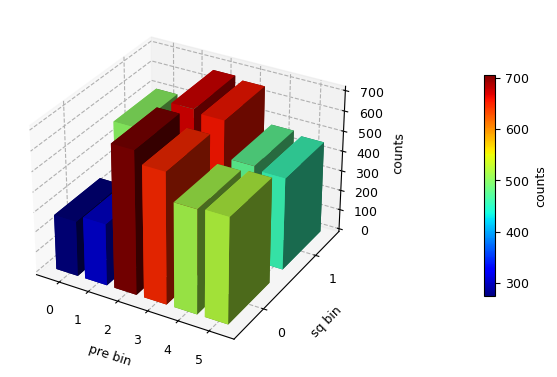

In [26]:
pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)

print(sq.shape, pre.shape, obl.shape)

from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

_ = sa.count_sq_pre_contexts_3d(sq, pre, nbins_pre=6)
_ = sa.count_sq_pre_contexts_3d(sq, obl, nbins_pre=6)

# Influence of noise: test on different pre bin numbers, length of history (k)

In [20]:

print("Are there any NaN values in the interpolated sq data?", df_sq_i.isnull().values.any())
print("Are there any NaN values in the interpolated pre data?", df_pre_i.isnull().values.any())

Are there any NaN values in the interpolated sq data? False
Are there any NaN values in the interpolated pre data? False


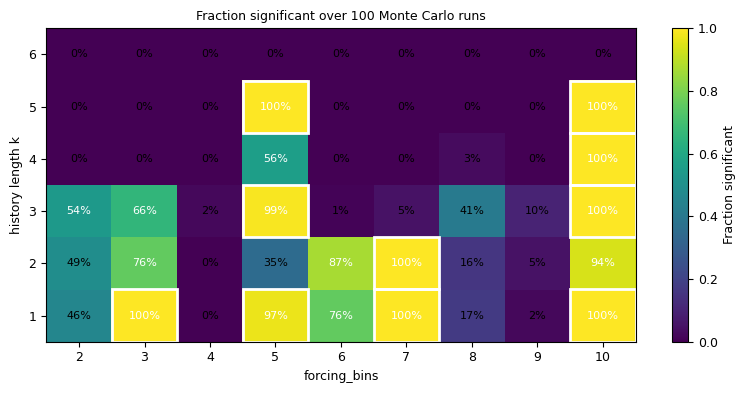

In [27]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



# df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 100, if_plot=False)


fractions= sa.mc_TE_heatmap(
    pre =df_pre_i['pre'].values,
    sq =df_sq_i['filt_d18O'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    plot=True)

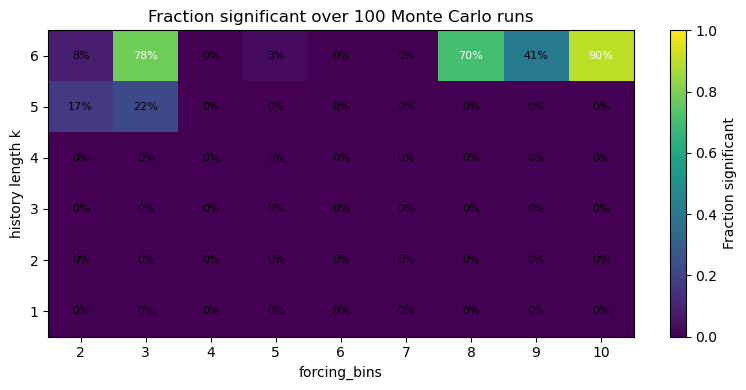

In [39]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 100, if_plot=False)

fractions= sa.mc_TE_heatmap(
    pre =df_obl_i['obl'].values,
    sq =df_sq_i['filt_d18O'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    plot=True)

# Influence of noise, test on different dt

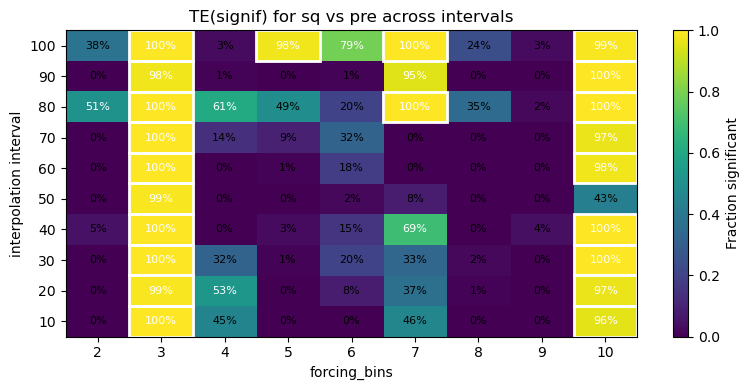

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


f=sa.mc_TE_heatmap_inter(
    df_filt_d18O.copy(),
    target_column='filt_d18O',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    forcing_var='pre',
    plot=True
)

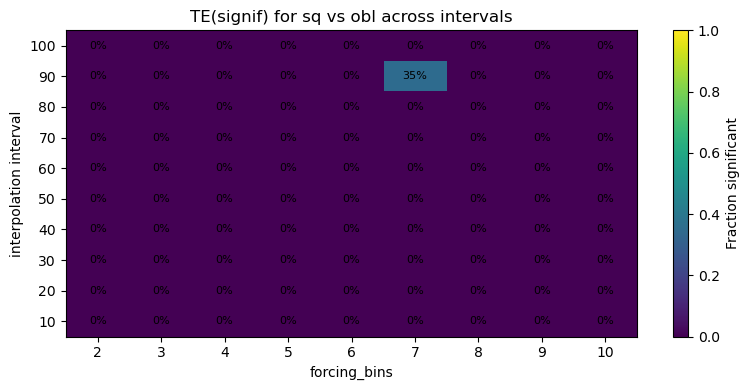

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



f=sa.mc_TE_heatmap_inter(
    df_filt_d18O.copy(),
    target_column='filt_d18O',
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.95,
    n_jobs=-1,
    if_plot=False,
    forcing_var='obl',
    plot=True
)

# Influence of age scale uncertainty: random scaling experiment

In [17]:
import numpy as np
from toolbox import sq_ana as sa
import importlib
importlib.reload(sa)

# how many random trials?
N = 100

# your maximum age error (as ratio)
max_age_error = 10000
max_age_ratio = max_age_error / np.max(df_filt_d18O['age'].values)

# sigma so that ±2σ = ±max_age_ratio
sigma = max_age_ratio / 2.0

# counters
count_pre_sq = 0
count_obl_sq = 0

for _ in range(N):
    # draw a random ratio, truncated to [-max_age_ratio, +max_age_ratio]
    r = np.random.normal(0, sigma)
    r = np.clip(r, -max_age_ratio, max_age_ratio)
    
    # stretch your age axis
    df_sq_stretch = df_filt_d18O.copy()
    df_sq_stretch['age'] = df_sq_stretch['age'].values * (1.0 + r)
    
    # re-interpolate
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(
        df_sq_stretch, 20, if_plot=False
    )
    
    pre = df_pre_i['pre'].values
    obl = df_obl_i['obl'].values
    sq  = df_sq_i['filt_d18O'].values
    
    # test pre → sq
    result_pre, _ = sa.transfer_entropy_surrogate_test(
        pre, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_pre:
        count_pre_sq += 1
    
    # test obl → sq
    result_obl, _ = sa.transfer_entropy_surrogate_test(
        obl, sq, forcing_bins=6, sq_bins=2, if_plot=False
    )
    if result_obl:
        count_obl_sq += 1

# report
print(f"Out of {N} random age-errors:")
print(f"  pre → sq was significant in {count_pre_sq} runs")
print(f"  obl → sq was significant in {count_obl_sq} runs")


Out of 100 random age-errors:
  pre → sq was significant in 72 runs
  obl → sq was significant in 100 runs


# Influence of noise: random thining

In [20]:
import numpy as np
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)

def convergence_test(x, y, thinning_fractions, **te_kwargs):
    results = []
    N = len(x)
    for frac in thinning_fractions:
        m = int(N * frac)
        idx = np.sort(np.random.choice(N, m, replace=False))
        sig, te = sa.transfer_entropy_surrogate_test(
            x[idx], y[idx], if_plot=False, **te_kwargs
        )
        results.append((frac, sig))
    return results

fractions = np.linspace(0.2,1.0,5)   # 20%, 40%, …100%
print(convergence_test(pre, sq, fractions,
                       forcing_bins=6, sq_bins=2))

print(convergence_test(obl, sq, fractions,
                       forcing_bins=6, sq_bins=2))



[(0.2, False), (0.4, True), (0.6000000000000001, False), (0.8, True), (1.0, False)]
[(0.2, True), (0.4, True), (0.6000000000000001, True), (0.8, True), (1.0, True)]


# The influence of different bining plan ([max-min]/2; median; k-means)

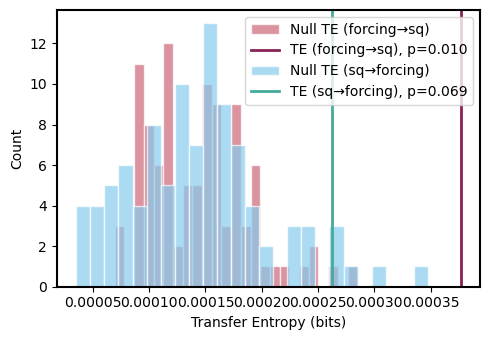

True


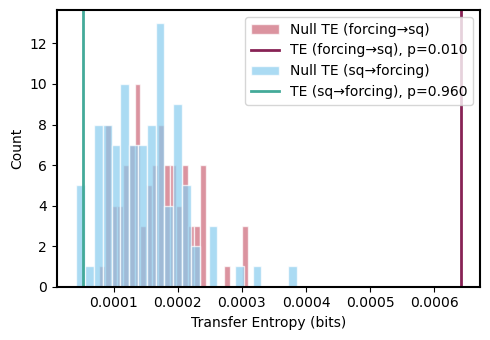

True


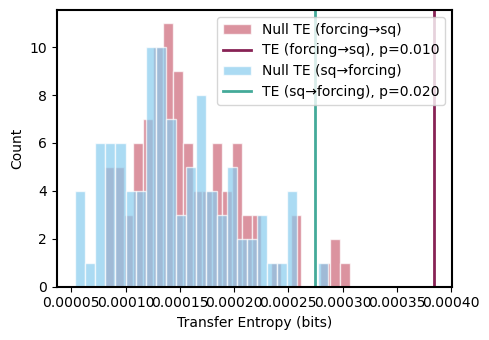

False


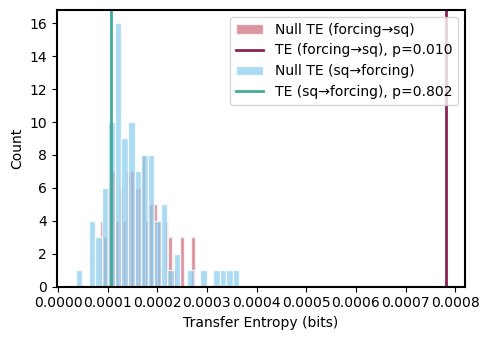

True


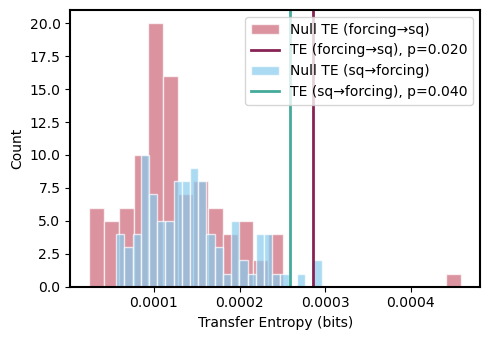

False


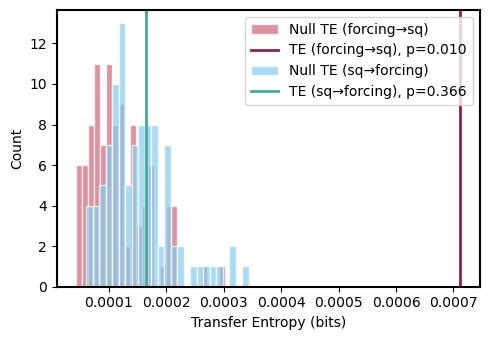

True


In [21]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


# sq_method='hist',  # options: 'hist', 'quantile', 'kmeans'

result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)



result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
print(result)

# Influence of "echo" random shift experiment

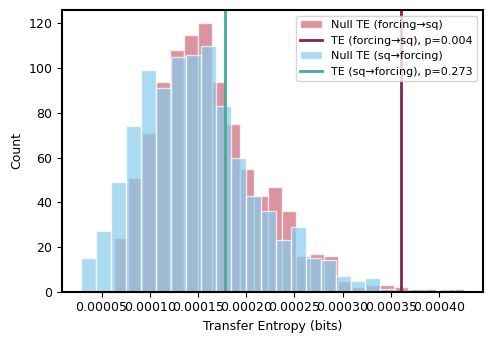

True


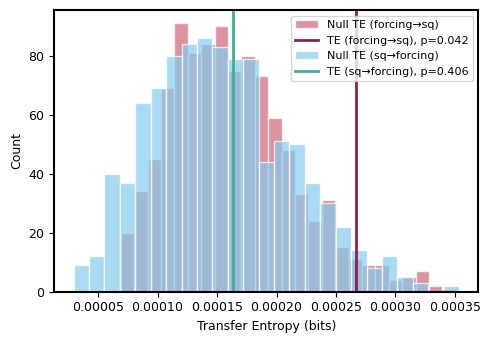

True


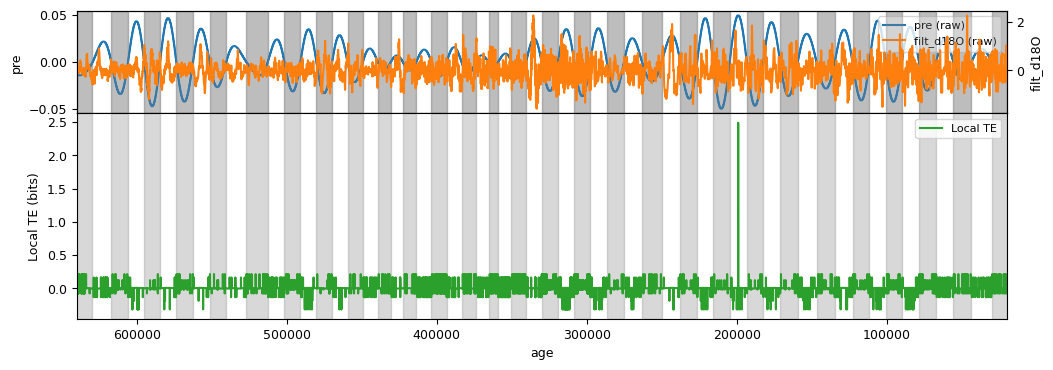

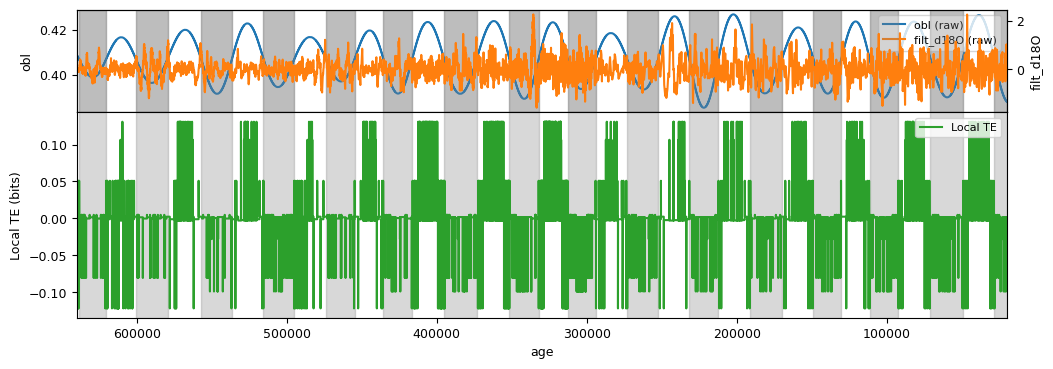

In [28]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)





df_sq_i, df_pre_i, df_obl_i = sa.create_shift_forcing(df_filt_d18O.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')
print(result)


result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, n_surr=1000)
print(result)



LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

# Some other tests

# Check what the null Pre (random swap) looks like

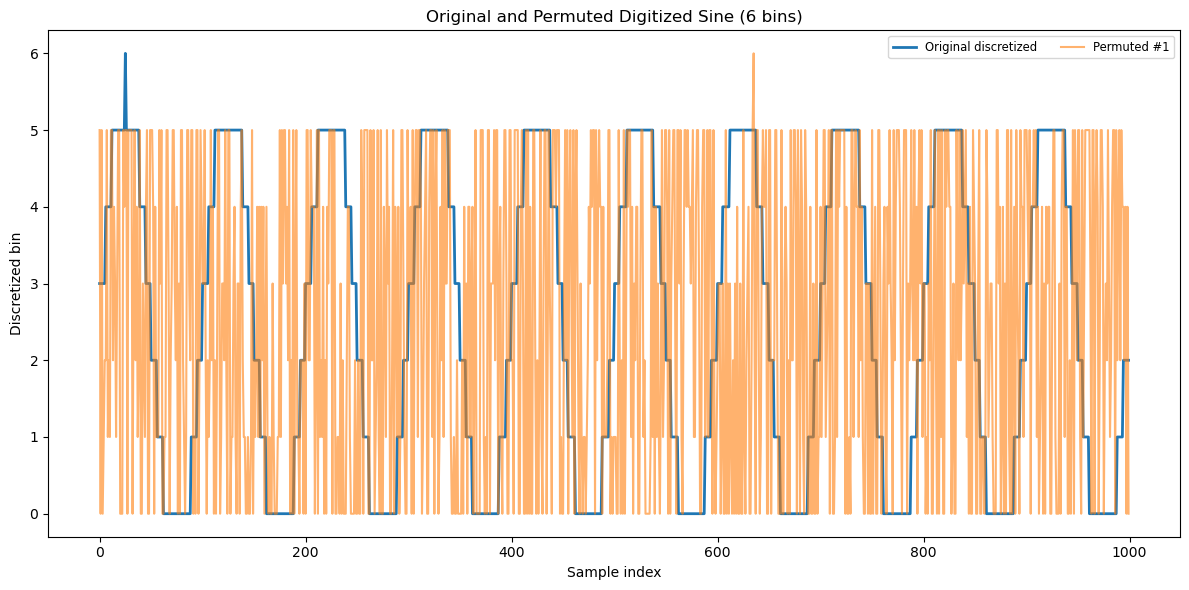

In [439]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sine wave with 10 cycles
cycles = 10
N = 1000
t = np.linspace(0, cycles * 2 * np.pi, N)
pre = np.sin(t)

# Discretize into 6 bins
edges = np.histogram_bin_edges(pre, bins=6)
pre_disc = np.digitize(pre, edges) - 1

# Generate 10 permuted surrogates
surrogates = [np.random.permutation(pre_disc) for _ in range(10)]

# Plot original and surrogates
plt.figure(figsize=(12, 6))
plt.plot(pre_disc, label='Original discretized', linewidth=2)
for i, s in enumerate(surrogates, 1):
    plt.plot(s, alpha=0.6, label=f'Permuted #{i}')
    if i == 1:
        break
plt.xlabel('Sample index')
plt.ylabel('Discretized bin')
plt.title('Original and Permuted Digitized Sine (6 bins)')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


# The d18O bins

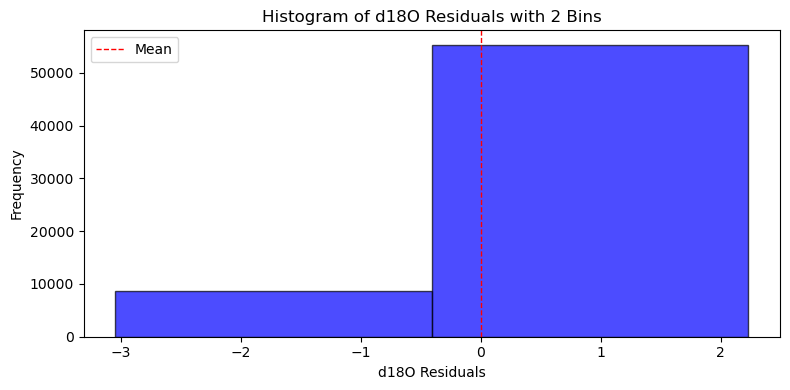

In [23]:
# plot the histogram of sq with bins=2
plt.figure(figsize=(8, 4))
plt.hist(sq, bins=2, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of d18O Residuals with 2 Bins')
plt.xlabel('d18O Residuals')
plt.ylabel('Frequency')
plt.axvline(np.mean(sq), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.legend()
plt.tight_layout()